In [1]:
import polars as pl

In [5]:
DATA_PATH = "data/ubc_data"
ATC_PATH = f"{DATA_PATH}/input/add_to_cart.parquet"
PV_PATH = f"{DATA_PATH}/input/page_visit.parquet"
PB_PATH = f"{DATA_PATH}/input/product_buy.parquet"
RFC_PATH = f"{DATA_PATH}/input/remove_from_cart.parquet"
SQ_PATH = f"{DATA_PATH}/input/search_query.parquet"
PP_PATH = f"{DATA_PATH}/product_properties.parquet"

In [6]:
atc_df = pl.read_parquet(ATC_PATH)
pv_df = pl.read_parquet(PV_PATH)
pb_df = pl.read_parquet(PB_PATH)
rfc_df = pl.read_parquet(RFC_PATH)
sq_df = (
    pl.read_parquet(SQ_PATH).with_columns(
        pl.col("query").str.extract_all(r"\d+").cast(pl.List(pl.Int64))
    )
)
pp_df = (
    pl.read_parquet(PP_PATH)
    .with_columns(
        pl.col("name").str.extract_all(r"\d+").cast(pl.List(pl.Int64))
    )
)

In [ ]:
atc_df.head(), pv_df.head(), pb_df.head(), rfc_df.head(), sq_df.head(), pp_df.head()

In [ ]:
# Get statistics for all tables

# Count distinct values in each dataframe
print("Distinct counts for Add to Cart (atc_df):")
print(f"Total rows: {atc_df.shape[0]}")
print(f"Distinct client_ids: {atc_df['client_id'].n_unique()}")
print(f"Distinct skus: {atc_df['sku'].n_unique()}")
print()

print("Distinct counts for Page Visit (pv_df):")
print(f"Total rows: {pv_df.shape[0]}")
print(f"Distinct client_ids: {pv_df['client_id'].n_unique()}")
print(f"Distinct urls: {pv_df['url'].n_unique()}")
print(f"Min url: {pv_df['url'].min()}")
print(f"Max url: {pv_df['url'].max()}")
print()

print("Distinct counts for Product Buy (pb_df):")
print(f"Total rows: {pb_df.shape[0]}")
print(f"Distinct client_ids: {pb_df['client_id'].n_unique()}")
print(f"Distinct skus: {pb_df['sku'].n_unique()}")
print()

print("Distinct counts for Remove from Cart (rfc_df):")
print(f"Total rows: {rfc_df.shape[0]}")
print(f"Distinct client_ids: {rfc_df['client_id'].n_unique()}")
print(f"Distinct skus: {rfc_df['sku'].n_unique()}")
print()

print("Distinct counts for Search Query (sq_df):")
print(f"Total rows: {sq_df.shape[0]}")
print(f"Min price in product properties: {pp_df['price'].min()}")
print(f"Max price in product properties: {pp_df['price'].max()}")
print(f"Min category in product properties: {pp_df['category'].min()}")
print(f"Max category in product properties: {pp_df['category'].max()}")
print(f"Distinct client_ids: {sq_df['client_id'].n_unique()}")
print(f"Distinct queries: {sq_df['query'].n_unique()}")
# For query, we need to handle the list type
print(f"Min values in query lists: {sq_df.select(pl.col('query').list.min().min())}")
print(f"Max values in query lists: {sq_df.select(pl.col('query').list.max().max())}")
print()

print("Distinct counts for Product Properties (pp_df):")
print(f"Total rows: {pp_df.shape[0]}")
print(f"Distinct skus: {pp_df['sku'].n_unique()}")
print(f"Distinct categories: {pp_df['category'].n_unique()}")
print(f"Distinct prices: {pp_df['price'].n_unique()}")
# For name, we need to handle the list type
print(f"Min values in name lists: {pp_df.select(pl.col('name').list.min().min())}")
print(f"Max values in name lists: {pp_df.select(pl.col('name').list.max().max())}")
print()


In [ ]:
# Join each dataframe with product properties on the correct column

# For most dataframes, product id is called "sku"
atc_with_props = atc_df.join(pp_df, left_on="sku", right_on="sku", how="left")
pb_with_props = pb_df.join(pp_df, left_on="sku", right_on="sku", how="left")
rfc_with_props = rfc_df.join(pp_df, left_on="sku", right_on="sku", how="left")
# No join for page visits

# Display the first few rows of each joined dataframe to verify
print("Add to cart with product properties:")
print(atc_with_props.head())

print("\nProduct buy with product properties:")
print(pb_with_props.head())

print("\nRemove from cart with product properties:")
print(rfc_with_props.head())

# Check for nulls in each joined dataframe
print("\nNull counts in Add to cart with product properties:")
print(atc_with_props.null_count())

print("\nNull counts in Product buy with product properties:")
print(pb_with_props.null_count())

print("\nNull counts in Remove from cart with product properties:")
print(rfc_with_props.null_count())

# Check for nulls in the other dataframes
print("\nNull counts in Search Query dataframe:")
print(sq_df.null_count())

print("\nNull counts in Page Visit dataframe:")
print(pv_df.null_count())

# Check percentage of nulls in key columns
print("\nPercentage of nulls in key columns:")
for df_name, df in [
    ("Add to cart", atc_with_props),
    ("Product buy", pb_with_props),
    ("Remove from cart", rfc_with_props)
]:
    total_rows = df.shape[0]
    if total_rows > 0:
        null_pct_category = (df["category"].null_count() / total_rows) * 100
        null_pct_price = (df["price"].null_count() / total_rows) * 100
        print(f"{df_name}: category {null_pct_category:.2f}%, price {null_pct_price:.2f}%")


In [ ]:
# Add event_type column to each dataframe before concatenation
atc_with_props = atc_with_props.with_columns(pl.lit("add_to_cart").alias("event_type"))
pb_with_props = pb_with_props.with_columns(pl.lit("product_buy").alias("event_type"))
rfc_with_props = rfc_with_props.with_columns(pl.lit("remove_from_cart").alias("event_type"))
sq_df = sq_df.with_columns(pl.lit("search_query").alias("event_type"))
pv_df = pv_df.with_columns(pl.lit("page_visit").alias("event_type"))

# Get all column names from the product events dataframes
all_columns = set()
for df in [atc_with_props, pb_with_props, rfc_with_props, pv_df, sq_df]:
    all_columns.update(df.columns)

# Ensure all dataframes have the same schema by adding missing columns with null values
for col in all_columns:
    # Add to cart
    if col not in atc_with_props.columns:
        atc_with_props = atc_with_props.with_columns(pl.lit(None).alias(col))
    # Product buy
    if col not in pb_with_props.columns:
        pb_with_props = pb_with_props.with_columns(pl.lit(None).alias(col))
    # Remove from cart
    if col not in rfc_with_props.columns:
        rfc_with_props = rfc_with_props.with_columns(pl.lit(None).alias(col))
    # Page visit
    if col not in pv_df.columns:
        pv_df = pv_df.with_columns(pl.lit(None).alias(col))
    # Search query
    if col not in sq_df.columns:
        sq_df = sq_df.with_columns(pl.lit(None).alias(col))

# Create a list of dataframes for concatenation
all_events = [atc_with_props, pb_with_props, rfc_with_props, pv_df, sq_df]
all_events_df = pl.concat(all_events, how="diagonal_relaxed")

all_events_df = (
    all_events_df
    .with_columns([
        pl.col("timestamp").dt.epoch("s").alias("timestamp"),
        pl.col("url").fill_null(pl.lit(-1)).alias("url"),
        pl.col("name").fill_null(pl.lit([-1]*16)).alias("name"),
        pl.col("query").fill_null(pl.lit([-1]*16)).alias("query"),
        pl.col("category").fill_null(pl.lit(-1)).alias("category"),
        pl.col("price").fill_null(pl.lit(-1)).alias("price"),
        pl.col("sku").fill_null(pl.lit(-1)).alias("sku"),
        ])
)


# Display the concatenated events
print("All events (add_to_cart, product_buy, remove_from_cart, page_visit, search_query):")
print(all_events_df.head())
print(f"Total rows in concatenated events: {all_events_df.shape[0]}")


In [8]:
all_events_df.write_parquet("data/all_events.parquet")

In [ ]:
all_events_df = pl.read_parquet("data/all_events.parquet")
all_events_df.head()

In [ ]:
# Create histograms and statistics for each event type and numeric columns
import matplotlib.pyplot as plt
import numpy as np

# Define the numeric columns to analyze
numeric_cols = ["sku", "category", "price"]
event_types = all_events_df["event_type"].unique().to_list()

# Create a figure with subplots for each event type and numeric column
fig, axes = plt.subplots(len(event_types), len(numeric_cols), figsize=(15, 4*len(event_types)))

# For storing statistics
stats_data = []

for i, event_type in enumerate(event_types):
    # Filter data for this event type
    event_df = all_events_df.filter(pl.col("event_type") == event_type)
    
    for j, col in enumerate(numeric_cols):
        # Get the data for this column
        col_data = event_df.select(col).to_numpy().flatten()
        
        # Remove -1 values (which were used for filling nulls)
        col_data = col_data[col_data != -1]
        
        if len(col_data) > 0:
            # Calculate statistics
            mean_val = np.mean(col_data)
            median_val = np.median(col_data)
            p75 = np.percentile(col_data, 75)
            p95 = np.percentile(col_data, 95)
            p99 = np.percentile(col_data, 99)
            
            # Store statistics
            stats_data.append({
                "event_type": event_type,
                "column": col,
                "mean": mean_val,
                "median": median_val,
                "p75": p75,
                "p95": p95,
                "p99": p99
            })
            
            # Plot histogram
            ax = axes[i, j]
            ax.hist(col_data, bins=30, alpha=0.7)
            ax.set_title(f"{event_type} - {col}")
            ax.set_xlabel(col)
            ax.set_ylabel("Frequency")
            
            # Add vertical lines for statistics
            ax.axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
            ax.axvline(median_val, color='g', linestyle='--', label=f'Median: {median_val:.2f}')
            ax.axvline(p95, color='b', linestyle='--', label=f'95th: {p95:.2f}')
            
            ax.legend(fontsize='small')
        else:
            axes[i, j].text(0.5, 0.5, f"No valid data for {event_type} - {col}", 
                           horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
plt.show()

# Create a DataFrame with the statistics and display it
stats_df = pl.DataFrame(stats_data)
print("Statistics by event type and column:")
print(stats_df)


In [ ]:
# Process user events in chunks to avoid OOM issues
# Get unique client_ids
unique_client_ids = all_events_df.select("client_id").unique().sort("client_id")
total_clients = unique_client_ids.shape[0]
print(f"Total unique clients to process: {total_clients}")

# Define chunk size
chunk_size = 500000
num_chunks = (total_clients + chunk_size - 1) // chunk_size  # Ceiling division

# Initialize an empty list to store DataFrames for each chunk
user_events_chunks = []

# Make sure the tmp directory exists
import os
os.makedirs("data/user_events", exist_ok=True)

for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, total_clients)
    
    print(f"Processing chunk {i+1}/{num_chunks} (clients {start_idx} to {end_idx-1})")
    
    # Get client_ids for this chunk
    chunk_client_ids = unique_client_ids.slice(start_idx, end_idx - start_idx)
    
    # Filter events for these clients
    chunk_events = all_events_df.filter(
        pl.col("client_id").is_in(chunk_client_ids.select("client_id"))
    )
    
    # Group by client_id and aggregate
    chunk_user_events = (
        chunk_events
        .sort("timestamp")
        .group_by("client_id")
        .agg(
            pl.col("timestamp"),
            pl.col("event_type"),
            pl.col("sku"),
            pl.col("category"),
            pl.col("price"),
            pl.col("url"),  # page visit
            pl.col("name"),  # product
            pl.col("query")  # search query
        )
    )
    
    # Save this chunk to disk
    chunk_file = f"data/user_events/chunk_{i}.parquet"
    chunk_user_events.write_parquet(chunk_file)
    
    # Add to our list
    user_events_chunks.append(chunk_file)
    
    print(f"Chunk {i+1} processed and saved to {chunk_file}")

In [2]:
user_events_df = pl.read_parquet("data/user_events")
user_events_df.head()

client_id,timestamp,event_type,sku,category,price,url,name,query
i64,list[i64],list[str],list[i64],list[i64],list[i64],list[i64],list[list[i64]],list[list[i64]]
273869,"[1656098039, 1656098535, … 1656098685]","[""page_visit"", ""page_visit"", … ""page_visit""]","[-1, -1, … -1]","[-1, -1, … -1]","[-1, -1, … -1]","[8044663, 9983479, … 9983479]","[[-1, -1, … -1], [-1, -1, … -1], … [-1, -1, … -1]]","[[-1, -1, … -1], [-1, -1, … -1], … [-1, -1, … -1]]"
336231,"[1654151180, 1654151215, … 1660300715]","[""page_visit"", ""page_visit"", … ""page_visit""]","[-1, -1, … -1]","[-1, -1, … -1]","[-1, -1, … -1]","[4996471, 4996471, … 6771158]","[[-1, -1, … -1], [-1, -1, … -1], … [-1, -1, … -1]]","[[-1, -1, … -1], [-1, -1, … -1], … [-1, -1, … -1]]"
675597,"[1657636380, 1657641065]","[""page_visit"", ""page_visit""]","[-1, -1]","[-1, -1]","[-1, -1]","[9968076, 10916464]","[[-1, -1, … -1], [-1, -1, … -1]]","[[-1, -1, … -1], [-1, -1, … -1]]"
399954,"[1654525325, 1654627085, … 1654627145]","[""page_visit"", ""page_visit"", … ""page_visit""]","[-1, -1, … -1]","[-1, -1, … -1]","[-1, -1, … -1]","[3031884, 12782511, … 10564051]","[[-1, -1, … -1], [-1, -1, … -1], … [-1, -1, … -1]]","[[-1, -1, … -1], [-1, -1, … -1], … [-1, -1, … -1]]"
292069,"[1657600840, 1657600840, … 1659182970]","[""page_visit"", ""page_visit"", … ""page_visit""]","[-1, -1, … -1]","[-1, -1, … -1]","[-1, -1, … -1]","[12362121, 12362121, … 1361208]","[[-1, -1, … -1], [-1, -1, … -1], … [-1, -1, … -1]]","[[-1, -1, … -1], [-1, -1, … -1], … [-1, -1, … -1]]"


Count of users with sequence length > 1 and < 105:
8604542
Distribution of sequence lengths:
shape: (10, 2)
┌─────────────────┬────────────┐
│ sequence_length ┆ user_count │
│ ---             ┆ ---        │
│ u32             ┆ u32        │
╞═════════════════╪════════════╡
│ 2               ┆ 1931106    │
│ 3               ┆ 1408677    │
│ 4               ┆ 868313     │
│ 5               ┆ 638297     │
│ 6               ┆ 472025     │
│ 7               ┆ 376578     │
│ 8               ┆ 300252     │
│ 9               ┆ 250255     │
│ 10              ┆ 210936     │
│ 11              ┆ 181062     │
└─────────────────┴────────────┘


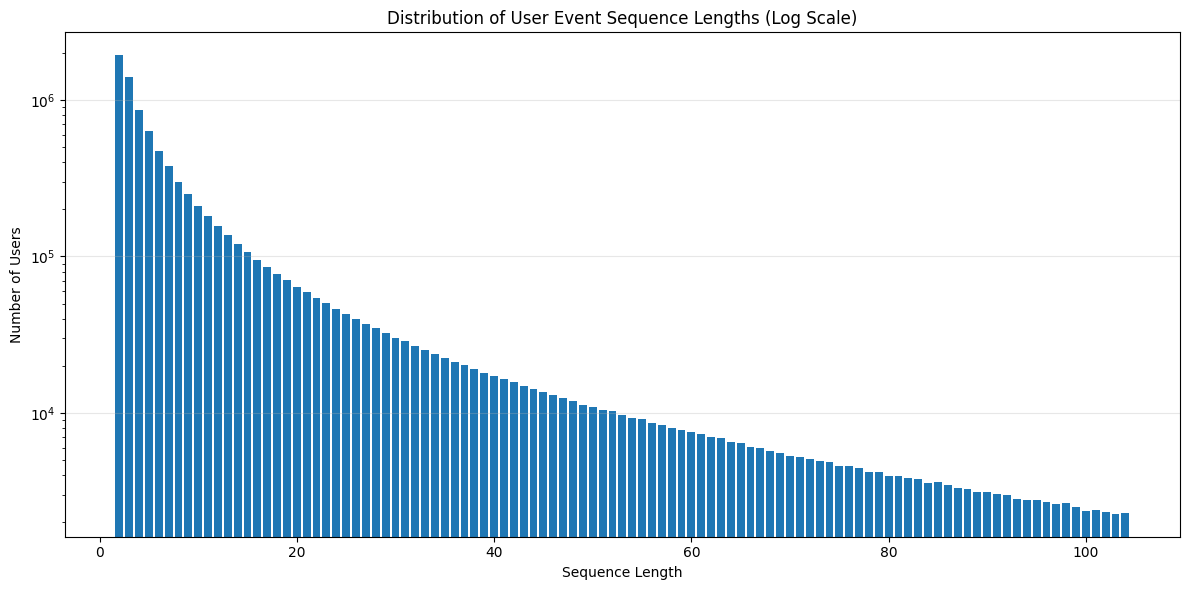


Sequence length statistics:
shape: (1, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ mean_lengt ┆ median_len ┆ min_length ┆ max_lengt ┆ q25_lengt ┆ q75_lengt ┆ q95_lengt ┆ q99_lengt │
│ h          ┆ gth        ┆ ---        ┆ h         ┆ h         ┆ h         ┆ h         ┆ h         │
│ ---        ┆ ---        ┆ u32        ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64        ┆ f64        ┆            ┆ u32       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 10.048025  ┆ 5.0        ┆ 2          ┆ 104       ┆ 3.0       ┆ 10.0      ┆ 39.0      ┆ 77.0      │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘


In [3]:
# Calculate the length of each user's event sequence
user_sequence_lengths = user_events_df.select([
    pl.col("client_id"),
    pl.col("event_type").list.len().alias("sequence_length")
]).filter(pl.col("sequence_length") > 1).filter(pl.col("sequence_length") < 105)

print("Count of users with sequence length > 1 and < 105:")
print(user_sequence_lengths.shape[0])

# Group by sequence length and count users
length_distribution = user_sequence_lengths.group_by("sequence_length").agg(
    pl.len().alias("user_count")
).sort("sequence_length")

print("Distribution of sequence lengths:")
print(length_distribution.head(10))

# Plot the distribution
import matplotlib.pyplot as plt
import numpy as np

# Convert to pandas for easier plotting
length_dist_pd = length_distribution.to_pandas()

plt.figure(figsize=(12, 6))
plt.bar(length_dist_pd["sequence_length"], length_dist_pd["user_count"])
plt.xlabel("Sequence Length")
plt.ylabel("Number of Users")
plt.title("Distribution of User Event Sequence Lengths")

# If there are many sequence lengths, use log scale for better visualization
if length_distribution.shape[0] > 50:
    plt.yscale("log")
    plt.title("Distribution of User Event Sequence Lengths (Log Scale)")

# Add grid for better readability
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate some statistics
stats = user_sequence_lengths.select([
    pl.col("sequence_length").mean().alias("mean_length"),
    pl.col("sequence_length").median().alias("median_length"),
    pl.col("sequence_length").min().alias("min_length"),
    pl.col("sequence_length").max().alias("max_length"),
    pl.col("sequence_length").quantile(0.25).alias("q25_length"),
    pl.col("sequence_length").quantile(0.75).alias("q75_length"),
    pl.col("sequence_length").quantile(0.95).alias("q95_length"),
    pl.col("sequence_length").quantile(0.99).alias("q99_length")
])

print("\nSequence length statistics:")
print(stats)


In [6]:
# Build vocabulary for categorical features
print("\nBuilding vocabularies for categorical features...")

# Function to build vocabulary from a column of lists
def build_vocabulary(df, column_name, min_freq=5, include_special_tokens=False):
    """
    Build vocabulary from a column containing lists of values.
    
    Args:
        df: Polars DataFrame
        column_name: Name of the column containing lists
        min_freq: Minimum frequency for an item to be included in vocabulary
        include_special_tokens: Whether to include special tokens like PAD, UNK
        
    Returns:
        Dictionary mapping tokens to indices and list of tokens
    """
    # Use polars to explode the lists and count frequencies
    value_counts = df.select(
        pl.col(column_name).explode()
    ).filter(
        pl.col(column_name).is_not_null()
    ).group_by(
        column_name
    ).len().sort(
        "count", descending=True
    ).filter(
        pl.col("count") >= min_freq
    )
    
    # Get the filtered values as a list
    sorted_values = value_counts[column_name].to_list()
    
    # Create vocabulary with special tokens
    vocab = {}
    tokens = []
    
    idx = 0
    if include_special_tokens:
        # Add special tokens
        vocab["<PAD>"] = idx
        tokens.append("<PAD>")
        idx += 1
        
        vocab["<UNK>"] = idx
        tokens.append("<UNK>")
        idx += 1
    
    # Add regular tokens
    for value in sorted_values:
        vocab[value] = idx
        tokens.append(value)
        idx += 1
    
    return vocab, tokens

# Build vocabularies
event_type_vocab, event_type_tokens = build_vocabulary(user_events_df, "event_type")
sku_vocab, sku_tokens = build_vocabulary(user_events_df, "sku")
category_vocab, category_tokens = build_vocabulary(user_events_df, "category")

# Print vocabulary sizes
print(f"Event type vocabulary size: {len(event_type_vocab)}")
print(f"SKU vocabulary size: {len(sku_vocab)}")
print(f"Category vocabulary size: {len(category_vocab)}")

# Save vocabularies to text files
def save_vocabulary(tokens, filename):
    import os
    
    # Create data/vocabs directory if it doesn't exist
    os.makedirs("data/vocabs", exist_ok=True)
    
    # Save to the data/vocabs directory
    filepath = os.path.join("data/vocabs", filename)
    with open(filepath, 'w') as f:
        for token in tokens:
            f.write(f"{token}\n")
    print(f"Saved vocabulary to {filepath}")

# Save vocabularies
save_vocabulary(event_type_tokens, "event_type_vocab.txt")
save_vocabulary(sku_tokens, "sku_vocab.txt")
save_vocabulary(category_tokens, "category_vocab.txt")



Building vocabularies for categorical features...


/var/folders/ns/_8vp667s3gvfxcww_plg6qwc0000gn/T/ipykernel_51362/1541195696.py:25: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  ).count().sort(


Event type vocabulary size: 5
SKU vocabulary size: 241119
Category vocabulary size: 5854
Saved vocabulary to data/vocabs/event_type_vocab.txt
Saved vocabulary to data/vocabs/sku_vocab.txt
Saved vocabulary to data/vocabs/category_vocab.txt


In [ ]:
import tensorflow as tf
import polars as pl
import numpy as np

def create_tf_dataset(user_events_df: pl.DataFrame, 
                     batch_size: int = 32,
                     buffer_size: int = 10000,
                     max_seq_length: int = 100,
                     seed: int = 42):
    """
    Creates a TensorFlow dataset from user events dataframe that yields batches of randomly sampled data.
    
    Args:
        user_events_df: Polars DataFrame containing user event sequences
        batch_size: Size of batches to yield
        buffer_size: Size of shuffle buffer
        max_seq_length: Maximum sequence length to use (will pad/truncate to this length)
        seed: Random seed for reproducibility
        
    Returns:
        tf.data.Dataset that yields dictionary of batched tensors
    """
    
    # Convert lists to numpy arrays and pad/truncate to max_seq_length
    def process_sequence(seq, pad_value, dtype=np.int64):
        if len(seq) > max_seq_length:
            return np.array(seq[:max_seq_length], dtype=dtype)
        else:
            return np.pad(seq, (0, max_seq_length - len(seq)), 
                         constant_values=pad_value)

    # Process each column into padded numpy arrays
    processed_data = {
        'timestamp': np.stack([process_sequence(x, pad_value=0) 
                             for x in user_events_df['timestamp'].to_list()]),
        'event_type': np.stack([process_sequence(x, pad_value='') 
                              for x in user_events_df['event_type'].to_list()]),
        'sku': np.stack([process_sequence(x, pad_value=-1) 
                        for x in user_events_df['sku'].to_list()]),
        'category': np.stack([process_sequence(x, pad_value=-1) 
                            for x in user_events_df['category'].to_list()]),
        'price': np.stack([process_sequence(x, pad_value=-1) 
                         for x in user_events_df['price'].to_list()]),
        'url': np.stack([process_sequence(x, pad_value=-1) 
                        for x in user_events_df['url'].to_list()]),
    }
    
    # Create sequence masks
    sequence_lengths = user_events_df['timestamp'].list.len()
    masks = np.zeros((len(user_events_df), max_seq_length))
    for i, length in enumerate(sequence_lengths):
        length = min(length, max_seq_length)
        masks[i, :length] = 1
    processed_data['mask'] = masks

    # Convert event types to integer ids
    unique_events = np.unique(processed_data['event_type'][processed_data['event_type'] != ''])
    event_to_id = {event: idx for idx, event in enumerate(unique_events)}
    event_ids = np.zeros_like(processed_data['event_type'], dtype=np.int64)
    for event, idx in event_to_id.items():
        event_ids[processed_data['event_type'] == event] = idx
    processed_data['event_type'] = event_ids

    # Create TF dataset
    dataset = tf.data.Dataset.from_tensor_slices(processed_data)
    
    # Shuffle and batch
    dataset = dataset.shuffle(buffer_size, seed=seed)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset, event_to_id

def get_data_pipeline(user_events_path: str,
                     batch_size: int = 32,
                     buffer_size: int = 10000,
                     max_seq_length: int = 100,
                     seed: int = 42):
    """
    Creates a data pipeline from user events parquet files.
    
    Args:
        user_events_path: Path to user events parquet files
        batch_size: Batch size for training
        buffer_size: Size of shuffle buffer
        max_seq_length: Maximum sequence length
        seed: Random seed
        
    Returns:
        tf.data.Dataset and event_to_id mapping
    """
    # Read user events data
    user_events_df = pl.read_parquet(user_events_path)
    
    # Filter sequences that are too long or too short
    sequence_lengths = user_events_df['timestamp'].list.len()
    user_events_df = user_events_df.filter(
        (sequence_lengths > 1) & (sequence_lengths < max_seq_length)
    )
    
    return create_tf_dataset(
        user_events_df,
        batch_size=batch_size,
        buffer_size=buffer_size,
        max_seq_length=max_seq_length,
        seed=seed
    )